# Análisis de Sentimientos usando RNN

Para experimentar el análisis de sentimientos mediante una red neuronal recurrente, se extrae como fuente *Large Movie Review Dataset* (IMDB) que posee 50.000 comentarios acerca de las películas, etiquetadas como buenas o malas. Ésta clasificación fue realizada en base al rating que cada usuario le puso a las películas, la escala es de 1 a 10, las reviews con rating ≤ 4 se consideraron negativas y con rating ≥ 7 positivas, el rango intermedio son ratings neutronales por lo tanto no fueron agregados al dataset.

La red neuronal recurrente utilzada para este problema es la *Long-Short Term Memory (LSTM)* que es especializada en clasificación y predicciones de series de tiempos.


In [2]:
import os, time
os.environ['THEANO_FLAGS'] = "device=gpu,floatX=float32,cuda.root=/usr/local/cuda-7.5/,nvcc.flags=-D_FORCE_INLINES" 

#import theano
import keras
import numpy as np
import collections as col

from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, LSTM,Dropout,SimpleRNN
from keras.layers.embeddings import Embedding

from matplotlib import pyplot as plt
%env OMP_NUM_THREADS=8

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce 940M (CNMeM is disabled, cuDNN 5110)


env: OMP_NUM_THREADS=8


Aquí se importan todas las librerias utilizadas para el desarrollo del problema, mayoritariamente derivadas de la librería keras que contiene el dataset imdb estructurada de manera sencilla para el uso en redes neuronales, y la implementación en código de la red LSTM entre otros.

## a) Cargar datos


In [2]:
np.random.seed(3)
(X_train, y_train), (X_test, y_test) = imdb.load_data(seed=15)
print("Dimensionalidades de conjunto entrenamiento: ",X_train.shape)
print("Dimensionalidades de conjunto pruebas: ",X_test.shape)

('Dimensionalidades de conjunto entrenamiento: ', (25000,))
('Dimensionalidades de conjunto pruebas: ', (25000,))


In [7]:
print "Cantidad de datos clase positiva: ", len(y_train[y_train == 1])
print "Cantidad de datos clase negativa: ",len(y_train[y_train == 0])
print "Etiquetas: ", set(y_train)

Cantidad de datos clase positiva:  12500
Cantidad de datos clase negativa:  12500
Etiquetas:  set([0, 1])


Del conjunto total de comentarios, el dataset se divide en 50% y 50%, cada porción correspondiente al conjunto de entrenamiento y conjunto de test. Cada porción tiene la mitad de comentarios positivos y negativos, para que la tarea del aprendizaje sea balanceada, tal cual se ve en la cantidad de ejemplos de cada clase, donde las etiquetas posibles son 1 (comentario positivo) y 0 (comentario negativo).  
Cada elemento del conjunto es un review de largo variable, esto es, una lista donde cada elemento corresponderá a un número entero que simboliza la frecuencia de esa palabra en el dataset entero. Los números 0, 1 ,2 son "protegidos" ya que simbolizan pad, inicio de comentario y un elemento desconocido. 

In [8]:
def aparicion_palabra(id_palabra,dataset):
    cantidad = 0
    for comentario in dataset:
        for palabra in comentario:
            if palabra == id_palabra:
                cantidad += 1
    return cantidad
aparicion_palabra(4,X_train)

336148

El numero que más se repite en los comentarios es el número 4, por ende de aquí hacia abajo comienza el ranking, este sería el primero en frecuencia, el número 5 sería el segundo y así sucesivamente. Está desplazado por la forma en que keras lo implementó.

In [5]:
print("Un review de ejemplo: \n")
comm = 9903
print(X_train[comm],"\nEste comentario fue:"+("positivo" if y_train[comm] else "negativo"))

Un review de ejemplo: 

[1, 87, 664, 44, 4, 456, 7, 7443, 12368, 315, 4, 249, 4270, 1274, 7, 32, 58, 15, 282, 584, 9, 138, 14, 144, 30, 6, 215, 67, 15865, 5923, 51, 2414, 72, 16, 24, 64, 4, 3034, 21, 4, 312, 1922, 11661, 5, 1748, 1267, 7, 49, 7, 134, 12368, 13, 104, 6, 176, 7, 5916, 62, 1041, 19, 72, 15, 11, 4, 1748, 2995, 36, 71, 11, 49, 7, 134, 12368, 62, 24, 7, 93, 12, 8, 4, 75528, 1873, 2918, 120, 3293, 17421, 7, 5745, 260, 301, 15, 13, 150, 28, 6, 2798, 1161, 18, 12368, 5, 13, 923, 1575, 6, 15342, 9, 6, 113, 10584, 292, 4, 785, 28, 6, 479, 7, 231, 87, 32615, 5, 15, 9, 51, 14, 9, 6, 87, 664] 
Este comentario fue:positivo


Esta fue la forma que keras encontró más conveniente adaptar los comentarios para trabajarlos en una red neuronal, donde cada palabra está indexada por un número entero, indicando su posición en algún diccionario, de la misma forma se puede recuperar el texto original:

In [6]:
inicio_indice=3
diccionario = keras.datasets.imdb.get_word_index()
diccionario = {palabra:(valor+inicio_indice) for palabra,valor in diccionario.items()}
diccionario["<PADDING>"] = 0
diccionario["<INICIO>"] = 1
diccionario["<DESCONOCIDO>"] = 2
#Ahora el valor es la llave para recuperar el texto
id_a_palabra = {valor:palabra for palabra,valor in diccionario.items()}

def texto(dic,comentario):
    print(' '.join(dic[w] for w in comentario))

texto(id_a_palabra,X_train[comm])


<INICIO> great documentary about the lives of ny firefighters during the worst terrorist attack of all time that reason alone is why this should be a must see collectors item what shocked me was not only the attacks but the high fat diet and physical appearance of some of these firefighters i think a lot of doctors would agree with me that in the physical shape they were in some of these firefighters would not of made it to the 79th floor carrying over 60 lbs of gear having said that i now have a greater respect for firefighters and i realize becoming a firefighter is a life altering job the french have a history of making great documentary's and that is what this is a great documentary


In [7]:
id_a_palabra[4]

'the'

Podemos recuperar la palabra 4 que es la de mayor frecuencia, la palabra que simboliza es "the". Tiene sentido que esta se repita a lo largo del data dado que es un conector muy importante en el lenguaje del inglés.

## b) Distribucion del largo


Distribución de largo de comentarios: 


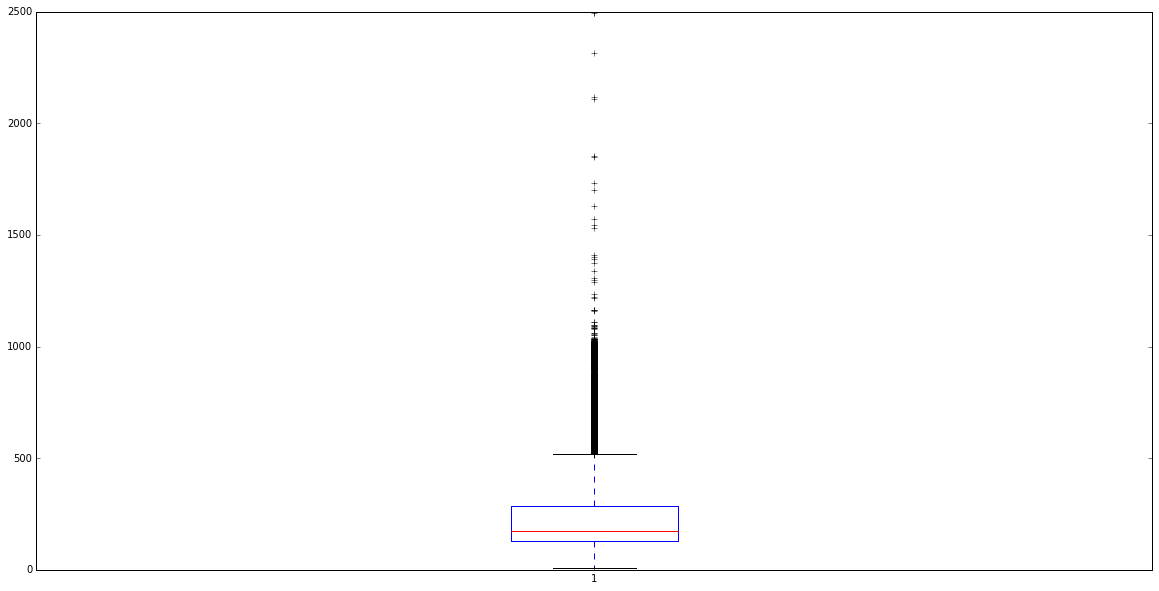

('Mediana del largo de comentarios:', array([ 176.,  176.]))
('Promedio de largo de comentarios:', 234.75891999999999, ' \xc2\xb1 ', 172.91149458735703)
('Comentario mas largo:', 2494)
('Comentario m\xc3\xa1s corto:', 7)


In [12]:
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

print("Distribución de largo de comentarios: ")
result = list(map(len, X))
plt.figure(figsize=(20,10))
box = plt.boxplot(result)
plt.show()
print("Mediana del largo de comentarios:",box['medians'][0].get_ydata())
print("Promedio de largo de comentarios:",np.mean(result)," ± ",np.std(result))
print("Comentario mas largo:",np.max(result))
print("Comentario más corto:",np.min(result))

En este último boxplot se muestra la distribución de el largo de los comentarios del dataset, a partir de la mediana se puede analizar que al menos un 50% de los datos tienen a lo más 176 palabras. Hay comentarios outliers que son los que estan fuera de el alcance "normal" de datos, siendo bastante largos, destaca el comentario con 2494 palabras. Otra medida para estudiar la distribución es el promedio del largo de los comentarios que está entre los 234.75 ± 172.91 pero no es muy confiable por su alta desviación estándar.


### Frecuencia de palabras en el dataset

In [13]:
def dic_freq(dataset):
    frecuencias = {}
    for comentario in dataset:
        for palabra in comentario:
            if palabra not in frecuencias:
                frecuencias[palabra] = 1
            else:
                frecuencias[palabra] += 1
    return frecuencias

frecuencias = dic_freq(X)
vocabulario = len(frecuencias)
ploty = []
for valor,freq in frecuencias.items():
    ploty.append(freq)

plotx = range(vocabulario)
desc_freq = list(reversed(sorted(ploty)))
maximo = max(desc_freq)
print(maximo)

666757


Se procede a guardar todas las palabras con su ocurrencia para su posterior gráfica, la palabra que más se repite en el dataset es "the" con 666757 ocurrencias.

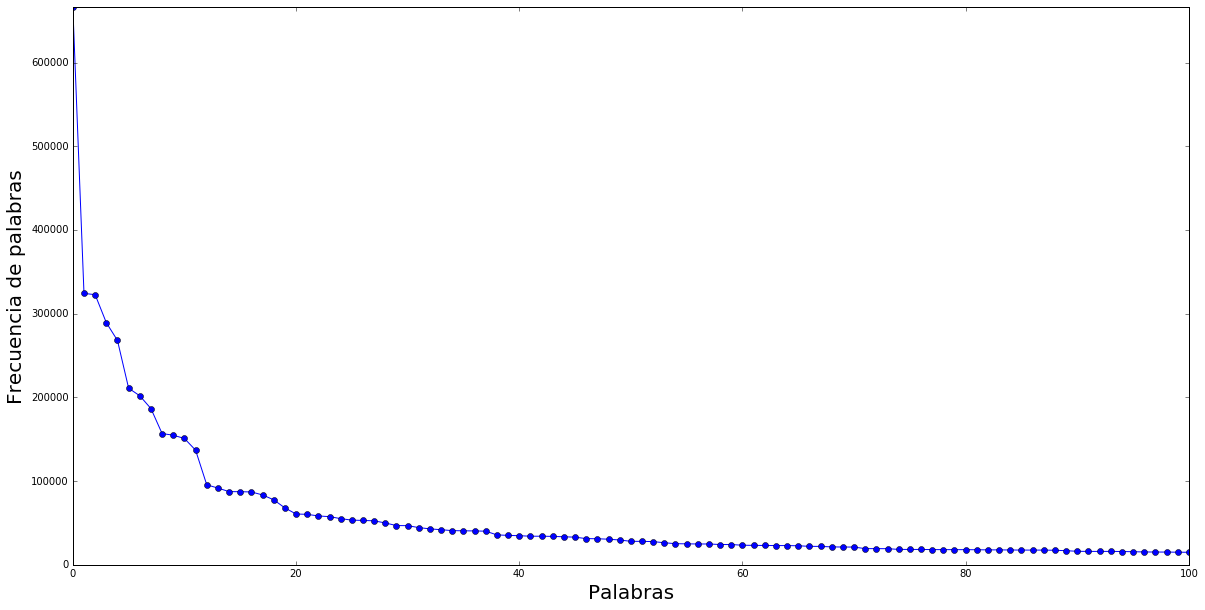

In [17]:
plt.figure(figsize=(20,10))
plt.plot(plotx,desc_freq,'bo-')
plt.xlabel("Palabras",fontsize=20)
plt.ylabel("Frecuencia de palabras",fontsize=20)
plt.xlim(0,100)
plt.ylim(0,666800)
plt.show()

Se ordenan las palabras con frecuencia descendente, se aprecia claramente una ley de Zipf o del mínimo esfuerzo. El gráfico denota que hay unas pocas palabras que son muchas veces utilizadas y muchas palabras que son poco utilizadas. Para efectos de visualización se graficaron las 100 primeras palabras más frecuentes, despúes de este punto la frecuencia de las palabras disminuye de manera drástica por lo que se ve una línea que tiende a 0, otra alternativa podría haber graficado en escala logarítmica. 

Generalmente son los conectores las palabras que lideran las mayores frecuencias por su importancia léxico-semántica. Se puede apreciar esto a continuación:

<html>
<head>
<style>
table, th, td {
    border: 1px solid black;
    border-collapse: collapse;
}
</style>
</head>
<body>

<table style="width:100%" class='table table-striped'>
  <tr>
    <th><center>Ranking</center></th>
    <th><center>Palabra</center></th> 
  </tr>
  <tr><th><center>1</center></th><th><center>the</center></th></tr><tr><th><center>2</center></th><th><center>and</center></th></tr><tr><th><center>3</center></th><th><center>a</center></th></tr><tr><th><center>4</center></th><th><center>of</center></th></tr><tr><th><center>5</center></th><th><center>to</center></th></tr><tr><th><center>6</center></th><th><center>is</center></th></tr><tr><th><center>7</center></th><th><center>br</center></th></tr><tr><th><center>8</center></th><th><center>in</center></th></tr><tr><th><center>9</center></th><th><center>it</center></th></tr><tr><th><center>10</center></th><th><center>i</center></th></tr><tr><th><center>11</center></th><th><center>this</center></th></tr><tr><th><center>12</center></th><th><center>that</center></th></tr><tr><th><center>13</center></th><th><center>was</center></th></tr><tr><th><center>14</center></th><th><center>as</center></th></tr><tr><th><center>15</center></th><th><center>for</center></th></tr><tr><th><center>16</center></th><th><center>with</center></th></tr><tr><th><center>17</center></th><th><center>movie</center></th></tr><tr><th><center>18</center></th><th><center>but</center></th></tr><tr><th><center>19</center></th><th><center>film</center></th></tr><tr><th><center>20</center></th><th><center>on</center></th></tr>
</table>
</body>
</html>

### Frecuencia de acuerdo a categoría

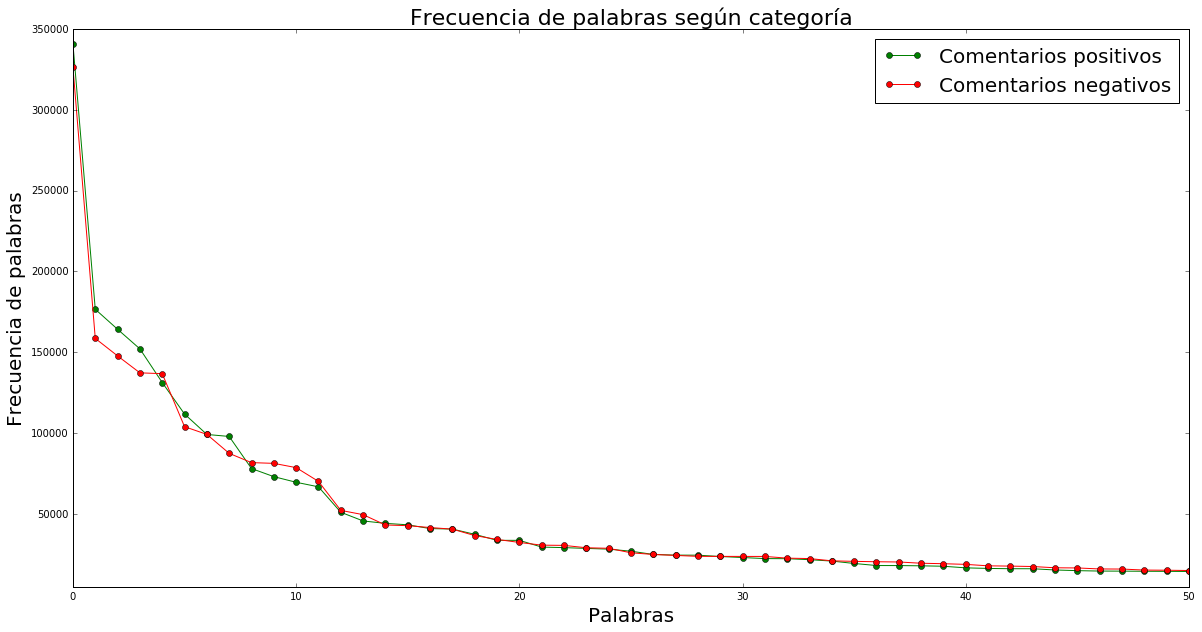

In [23]:
X_neg = []
X_pos = []
for i in range(len(X)):
    X_pos.append(X[i]) if (y[i]) else X_neg.append(X[i])

f_pos = dic_freq(X_pos)
vocabulario = len(f_pos)
plot_pos = []
for valor,freq in f_pos.items():
    plot_pos.append(freq)

f_neg = dic_freq(X_neg)
vocabulario2 = len(f_neg)
plot_neg = []
for valor,freq in f_neg.items():
    plot_neg.append(freq)

plotx = range(vocabulario)
plotx2= range(vocabulario2)
f_pos = list(reversed(sorted(plot_pos)))
f_neg = list(reversed(sorted(plot_neg)))
    
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(20,10))
axes.plot(plotx,f_pos, 'go-', label="Comentarios positivos")
axes.plot(plotx2,f_neg, 'ro-', label= "Comentarios negativos")
axes.set_title("Frecuencia de palabras según categoría",fontsize=22)
axes.set_ylabel("Frecuencia de palabras",fontsize=20)
axes.set_xlabel("Palabras",fontsize=20)
plt.xlim(0,50)
plt.ylim(5000)
axes.legend(loc='upper right',fontsize=20)
plt.show()
total = np.sum(f_pos)+np.sum(f_neg)
ppos= np.sum(f_pos)/float(total) * 100
pneg= np.sum(f_neg)/float(total) * 100
print("Total de palabras",total)
print(" % de palabras en comentarios negativos:",round(pneg,3))
print(" % de palabras en comentarios positivos:",round(ppos,3))
print(" Cantidad de palabras que difieren:",np.sum(f_pos)-np.sum(f_neg))

Se realiza el mismo procedimiento anterior, pero ahora separando el dataset entero en los 25.000 comentarios positivos y negativos, se observan algunos cambios en el resultado principalmente en las primeras 20 palabras. Se intercalan en la frecuencia las palabras en comentarios positivos y negativos, por ejemplo, las palabras *and* ,*a* y *of *aparecen más en comentarios positivos. Al contrario, las palabras *this*, *that* y *was* aparecen más en comentarios negativos que positivos. Puede influir la diferencia de palabras que hay en los comentarios, entre ellos, hay 71178 palabras más en los comentarios positivos que negativos. Estos pueden estar distribuidos en las primeras palabras lo que provoca este fenómeno.

## c) Comentarios de largo fijo 

In [15]:
top_words = 3000
max_review_len = 500
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words, seed=15)
X_train = sequence.pad_sequences(X_train, maxlen=max_review_len)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_len)
print("Nuevas dimensionalidades: ",X_train.shape)

Nuevas dimensionalidades:  (25000, 500)


Ahora se carga el dataset, pero esta vez acotando a las 3000 palabras más relevantes (frecuentes) de todo el *dataset* y limitando el largo máximo del comentario a una cantidad de 500 palabras. Los comentarios que posean menos palabras son rellenados con 0. Como vimos en el boxplot, la gran mayoría estará dentro de este rango de palabras, por lo tanto, será una pequeña cantidad de comentarios los cuales serán truncados dado que tienen más de 500 palabras.  
El *padding* de 0's es generalmente la mejor opción para rellenar matrices o vectores en general, en este caso, como es en contexto de una secuencia de palabras es idóneo ya que a medida que la red vaya aprendiendo, se dará cuenta que éste valor no tiene un significado propio por lo se percatará que es un simple rellenado sin información y no lo tomará en cuenta a la hora de las predicciones.

## d) Entrenar red LSMT

In [8]:
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_len))
model.add(LSTM(100))
model.add(Dense(1, activation="sigmoid"))
print model.summary()
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
hist1 = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)
scores1 = model.evaluate(X_test, y_test, verbose=0)

print "Accuracy score: ",scores1[1]
print "Binary Cross entropy loss: ", scores1[0]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 32)           96000     
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 149,301
Trainable params: 149,301
Non-trainable params: 0
_________________________________________________________________
None
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 334s - loss: 0.4627 - acc: 0.7736 - val_loss: 0.4825 - val_acc: 0.7750
Epoch 2/3
25000/25000 [==============================] - 323s - loss: 0.3125 - acc: 0.8712 - val_loss: 0.3166 - val_acc: 0.8692
Epoch 3/3
25000/25000 [==============================] - 325s - loss: 0.3332 - acc: 0.853

Se entrena una red Long Short Term Memory (LSTM) para clasificar cada comentario en positivo o negativo, se le presentan a la red los comentarios reducidos en 500 palabras. Cada elemento de un comentario corresponde a la frecuencia ordenada de las palabras, esto es una variable escencialmente categórico y no se puede entrenar sin realizar un ajuste. Para esto, se genera una representación vectorial para cada una para el posterior uso en la red.

Inicialmente se realiza una transformación del espacio de representación original con un embedding de dimensionalidad 32, esto es, cada palabra en un comentario es representado por un vector denso de 32 componentes. La siguiente capa tiene 100 neuronas (unidades) LSTM recurrentes, la última capa posee una única neurona con función de activación sigmoidal para hacer las predicciones entre positivo y negativo. Como este problema es de clasificación entre 2 clases, la función de pérdida adecuada y utilizada es la *binary cross-entropy*.

La red en 3 epochs converge rápidamente a buenos resultados, teniendo un tiempo alto de entrenamiento por epoch ( 320 segundos), entregando una precisión sobre el conjunto de test de 85% y un valor de función de pérdida en 35%. Es un resultado bueno porque actualmente el estado del arte para este problema,  alcanza un 88.9% (**Learning Word Vectors for Sentiment Analysis**, paper de Stanford) , valor muy cercano al 85% que alcanzó esta simple red la cual es el primer acercamiento al problema.

## e) Variación de embedding

In [9]:
embedding_vector_length = 32
embedding1 = int((embedding_vector_length)/2)
embedding2 = int(2*(embedding_vector_length))

#Con la mitad del embedding original
model = Sequential()
model.add(Embedding(top_words, embedding1, input_length=max_review_len))
model.add(LSTM(100))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
hist2 = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)
scores2 = model.evaluate(X_test, y_test, verbose=0)
print "Mitad del embedding original"
print "Accuracy score: ",scores2[1]
print "Binary Cross entropy loss: ", scores2[0]

#Con el doble del embedding original
model = Sequential()
model.add(Embedding(top_words, embedding2, input_length=max_review_len))
model.add(LSTM(100))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
hist3 = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)
scores3 = model.evaluate(X_test, y_test, verbose=0)
print "Doble del embedding original"
print "Accuracy score: ",scores3[1]
print "Binary Cross entropy loss: ", scores3[0]

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 320s - loss: 0.4947 - acc: 0.7574 - val_loss: 0.3678 - val_acc: 0.8436
Epoch 2/3
25000/25000 [==============================] - 319s - loss: 0.3481 - acc: 0.8526 - val_loss: 0.3394 - val_acc: 0.8556
Epoch 3/3
25000/25000 [==============================] - 320s - loss: 0.2689 - acc: 0.8916 - val_loss: 0.2977 - val_acc: 0.8756
Mitad del embedding original
Accuracy score:  0.8756
Binary Cross entropy loss:  0.297659356433
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 337s - loss: 0.4619 - acc: 0.7754 - val_loss: 0.3606 - val_acc: 0.8511
Epoch 2/3
25000/25000 [==============================] - 331s - loss: 0.3788 - acc: 0.8377 - val_loss: 0.4313 - val_acc: 0.8021
Epoch 3/3
25000/25000 [==============================] - 331s - loss: 0.2894 - acc: 0.8806 - val_loss: 0.3146 - val_acc: 0.8632
Doble del embedding original
Accurac

Se varía la dimensionalidad del embedding inicial, se entrenan 2 modelos, uno con la mitad y otro con el doble del embedding inicial para determinar si influye en la precisión del modelo, los tiempos de entrenamiento por *epoch* son similares, por lo que esto no tiene una gran influencia en el modelo.

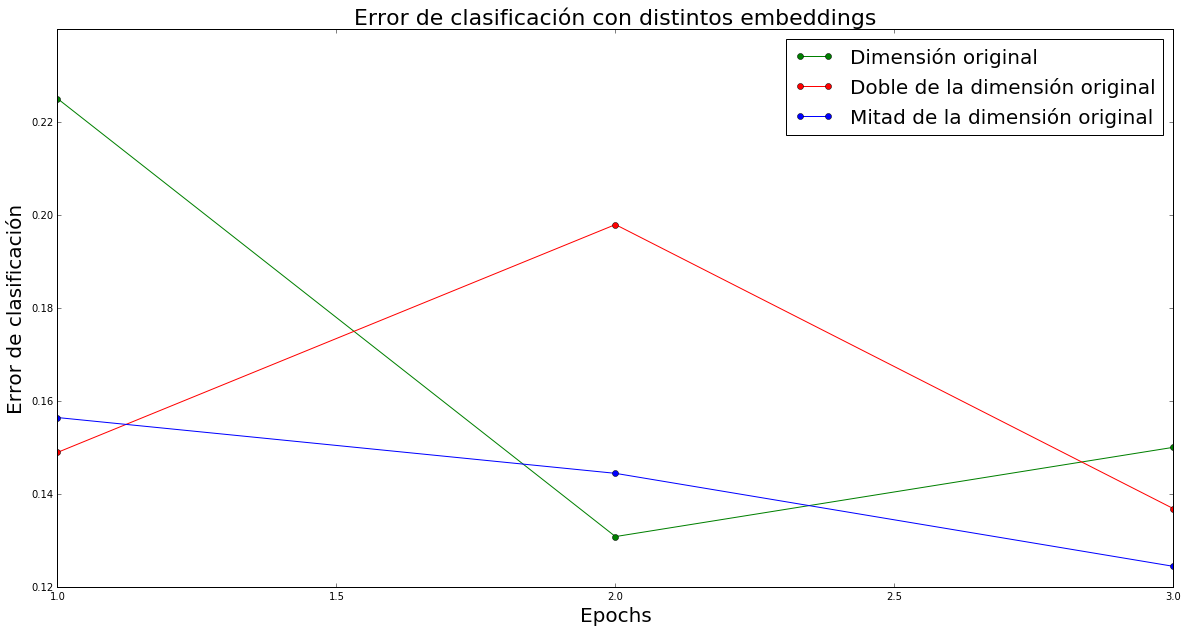

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(20,10))
embedding = [1-0.7750,1-0.8692,1-0.8500]
mitad_embedding = [1-0.8436,1-0.8556,1-0.8756]
doble_embedding = [1-0.8511,1-0.8021,1-0.8632]
axes.plot(range(1,4),embedding, 'go-', label="Dimensión original")
axes.plot(range(1,4),doble_embedding, 'ro-', label= "Doble de la dimensión original")
axes.plot(range(1,4),mitad_embedding, 'bo-', label= "Mitad de la dimensión original")
axes.set_title("Error de clasificación con distintos embeddings",fontsize=22)
axes.set_ylabel("Error de clasificación",fontsize=20)
axes.set_xlabel("Epochs",fontsize=20)
axes.legend(loc='upper right',fontsize=20)
plt.show()

Este gráfico muestra el error de clasificación en función de los epochs en el conjunto de validación (que en este caso equivale al conjunto de test) con distintas dimensionalidades de embedding. Se puede ver que el embedding con dimensión original de 32 comienza con un alto error de clasificación y disminuye de forma irregular en los siguientes epochs. El modelo con el doble de embedding inicial empieza con un bajo error pero aumenta y disminuye con los distintos epochs. El modelo más estable es el que posee la mitad de la dimensión original, dado que se mantiene a la baja de manera constante y acaba con el menor error de clasificación entre los 3. Por lo tanto, se puede decir que un embedding de 16 de dimensionalidad es el óptimo para el modelo en este caso, puesto que al contraer toda la información del comentario en 16 componentes resultó lo más útil. Hay que tener en cuenta que son 3 epochs, es posible que con más epochs hayan cambios pero el que más promete es el último modelo mencionado.

## f) Modificar número de palabras más frecuentes

In [10]:
#top words representa las top n palabras más frecuentes
top_words = 3000/2
max_review_len = 500
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words, seed=15)
X_train = sequence.pad_sequences(X_train, maxlen=max_review_len)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_len)

embedding_vector_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_len))
model.add(LSTM(100))
model.add(Dense(1, activation="sigmoid"))
print model.summary()
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)
scores = model.evaluate(X_test, y_test, verbose=0)

print "Top Words: ",top_words
print "Accuracy score: ",scores[1]
print "Binary Cross entropy loss: ", scores[0]

Nuevas dimensionalidades:  (25000, 500)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 500, 32)           48000     
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 101,301
Trainable params: 101,301
Non-trainable params: 0
_________________________________________________________________
None
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 322s - loss: 0.5257 - acc: 0.7283 - val_loss: 0.5965 - val_acc: 0.6602
Epoch 2/3
25000/25000 [==============================] - 322s - loss: 0.4023 - acc: 0.8196 - val_loss: 0.3628 - val_acc: 0.8481
Epoch 3/3
25000/25000 [==========================

Se entrena el mismo modelo definido anteriormente cambiando la cantidad de palabras que serán utilizadas. En la celda anterior con la mitad de las palabras utilizadas anteriormente, 1500, y en las siguientes celdas con el doble de la palabras utilizadas anteriormente, 6000. Con la mitad de las palabras utilizadas anteriormente se alcanza un *accuracy* más bajo, de valor 84,56%.

In [11]:
top_words = 3000*2
max_review_len = 500
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words, seed=15)
X_train = sequence.pad_sequences(X_train, maxlen=max_review_len)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_len)

embedding_vector_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_len))
model.add(LSTM(100))
model.add(Dense(1, activation="sigmoid"))
print model.summary()
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)
scores = model.evaluate(X_test, y_test, verbose=0)

print "Top Words: ",top_words
print "Accuracy score: ",scores[1]
print "Binary Cross entropy loss: ", scores[0]

Nuevas dimensionalidades:  (25000, 500)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 500, 32)           192000    
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 245,301
Trainable params: 245,301
Non-trainable params: 0
_________________________________________________________________
None
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 322s - loss: 0.4748 - acc: 0.7684 - val_loss: 0.3384 - val_acc: 0.8564
Epoch 2/3
25000/25000 [==============================] - 329s - loss: 0.2877 - acc: 0.8849 - val_loss: 0.3091 - val_acc: 0.8692
Epoch 3/3
25000/25000 [==========================

El *accuracy* obtenido agregando más palabras a ser utilizadas en los datos aumenta el *accuracy*, lo cual tiene sentido ya que se tienen más datos por lo tanto más información del comentario y su inclinación hacia alguna polaridad.  
Los tiempos de entrenar son similares para ambos casos, utilizando más palabras frecuentes y menos.

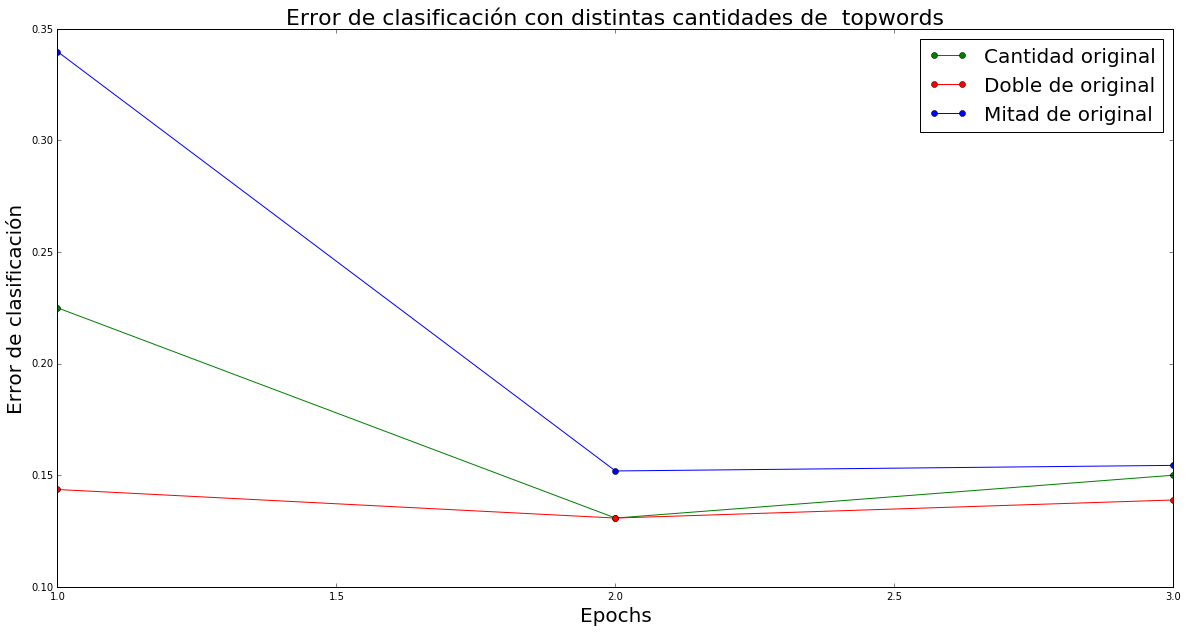

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(20,10))
topword = [1-0.7750,1-0.8692,1-0.8500]
mitad_topword = [1-0.6602,1-0.8481,1-0.8456]
doble_topword = [1-0.8564,1-0.8692,1-0.8611]
axes.plot(range(1,4),topword, 'go-', label="Cantidad original")
axes.plot(range(1,4),doble_topword , 'ro-', label= "Doble de original")
axes.plot(range(1,4),mitad_topword , 'bo-', label= "Mitad de original")
axes.set_title("Error de clasificación con distintas cantidades de  topwords",fontsize=22)
axes.set_ylabel("Error de clasificación",fontsize=20)
axes.set_xlabel("Epochs",fontsize=20)
axes.legend(loc='upper right',fontsize=20)
plt.show()

Nuevamente se consideran los casos donde se tiene el doble de la cantidad original de *topwords* (6000), la mitad (1500) y la comparación con la cantidad original (3000).

A partir del gráfico de error de clasificación en función de los epochs, se observa una tendencia en que utilizar el doble de palabras más frecuentes (*topwords*) disminuye el error de clasificación más que abarcando 1500 o 3000 *topwords*. Se puede especular que con un vocabulario más amplio es más fácil para la red aprender las secuencias de palabras debido a que cada comentario posee mayor información en los datos.

## g) Dropout para entrenar LSTM

In [4]:
top_words = 3000
max_review_len = 500
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words, seed=15)
X_train = sequence.pad_sequences(X_train, maxlen=max_review_len)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_len)

Se vuelven a cargar los datos como el primer modelo definido, con 3000 *top words*, para comparar con este.

In [5]:
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_len))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
print(model.summary())
model.fit(X_train, y_train, epochs=3, batch_size=64,verbose=1)
scores4 = model.evaluate(X_test, y_test, verbose=0)
print "Accuracy score: ",scores4[1]
print "Binary Cross entropy loss: ", scores4[0]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           96000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 149,301
Trainable params: 149,301
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
25000/25000 [==============================] - 298s - loss: 0.5275 - acc: 0.7132   
Epoch 2/3
25000/25000 [==============

En búsqueda de mejores resultados se usa Dropout para entrenar la red, se aplica en las capas entre el embedding-LSTM y entre las capas LSTM-NeuronaClasificadora. Se mantienen la estructura de 3000 *topwords* y 32 componentes en los vectores en la capa de embedding, los resultados son inesperados, ya que la nueva precisión del modelo es de 84,54% peor al 85% obtenido sin el Dropout, este resultado pudo ser debido a las condiciones del problema, donde no fue necesario utilizar Dropout para esa arquitectura con 3 epochs, ya que puede que si se entrenara durante más epochs la red, esta tendería a un mayor *overfitting*. Por ejemplo se hizo un experimento externo a la actividad donde se añadió el mismo Dropout a la estructura con 6000 *top words* y 32 componentes en los vectores, mejorando el desempeño de la red sobre el conjunto de pruebas, puesto que esta red es mas compleja debido a que tiene mas datos con los que se trabaja.  
Otro factor importante a comentar sobre el Dropout en redes recurrentes es que este debe ser implementado de una manera especial, siendo compartido por todos los bloques (unidades) en la capa de LSTM, ya que sino se puede perder el concepto de continuidad de las secuencias, debido a que este tipo de red detecta patrones en unas secuencias ordenadas, por lo que el Dropout aplicado no considera esto, pudiendo ocasionar desempeños peores. Dentro de la capa LSTM se puede seleccionar manualmente con el parámetro *dropout* dentro de la definición de esta capa, asociado al dropout de cada bloque.

El Dropout ignora ciertas neuronas para el entrenamiento, están "eliminadas" de manera aleatoria, otra forma de ver esto es que Dropout toma una muestra de las neuronas, ayudando a generalizar mediante una estimación del conjunto de entrenamiento. Este problema de clasificación tiende a tener *overfitting* debido a lo complejo del modelo y la gran cantidad de neuronas y conexiones en la arquitectura, además de que el aprender a partir de secuencias es una tarea bastante dificil. La finalidad es que hayan múltiples representaciones internas aprendidas por la red cuyo objetivo final es que la red se vuelva menos sensible a ciertos pesos y tenga una mejor capacidad de generalizar.

## h) Modelo propuesto para mejorar capacidad predictiva

In [8]:
top_words = 3000*2
max_review_len = 500
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words, seed=15)
X_train = sequence.pad_sequences(X_train, maxlen=max_review_len)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_len)

embedding_vector_length = 32/2
model = Sequential()
model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_len))
model.add(LSTM(100))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
print(model.summary())
model.fit(X_train, y_train, epochs=3, batch_size=64)
scores4 = model.evaluate(X_test, y_test, verbose=0)
print "Accuracy score: ",scores4[1]
print "Binary Cross entropy loss: ", scores4[0]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 16)           96000     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               46800     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 142,901
Trainable params: 142,901
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
25000/25000 [==============================] - 272s - loss: 0.5412 - acc: 0.7116   
Epoch 2/3
25000/25000 [==============================] - 274s - loss: 0.3028 - acc: 0.8772   
Epoch 3/3
25000/25000 [==============================] - 272s - loss: 0.2446 - acc: 0.9063   
Accuracy score:  0.8784
Binary Cross entropy loss:  0.317237780906


Se puede ver que con la variación asignada, mezclando un embedding mas pequeño (menos componentes) con más palabras a utilizar en el dataset (mayor *top words*), logra un mejor desempeño, obteniendo un *accuracy* de 87,84%, el valor más alto alcanzado en la actividad, gracias a que al mezclar estas 2 ideas se logra que se tengan más datos (palabras) con las cuales predecir la polaridad de los comentarios y que los comentarios se compriman a una representación más pequeña, pudiendo extraer las características relevantes del dataset.  
Otra variación que se puede realizar es cambiar el tamaño de los *batch* con los que se entrena la red, así teniendo una aproximación distinta durante cada iteración, que podría ayudar a converger al modelo.

In [17]:
top_words = 3000*2
max_review_len = 500
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words, seed=15)
X_train = sequence.pad_sequences(X_train, maxlen=max_review_len)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_len)

embedding_vector_length = 32/2
model = Sequential()
model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_len))
model.add(LSTM(100))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
print(model.summary())
model.fit(X_train, y_train, epochs=3, batch_size=100)
scores4 = model.evaluate(X_test, y_test, verbose=0)
print "Accuracy score: ",scores4[1]
print "Binary Cross entropy loss: ", scores4[0]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 16)           96000     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               46800     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 142,901
Trainable params: 142,901
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
25000/25000 [==============================] - 236s - loss: 0.5225 - acc: 0.7416   
Epoch 2/3
25000/25000 [==============================] - 247s - loss: 0.3051 - acc: 0.8756   
Epoch 3/3
25000/25000 [==============================] - 232s - loss: 0.2973 - acc: 0.8808   
Accuracy score:  0.86624
Binary Cross entropy loss:  0.33418248584


El modelo anterior se entrena con un tamaño de *batch* más grande que el anterior, reduciendo el tiempo de entrenamiento ya que son menos las iteraciones de cada *batchs* por *epochs*. Al obtener un *accuracy* menor que el anterior muestra que no mejora el desempeño al aumentar el tamaño del *batch* por lo que se queda con el anterior modelo, mostrando que con un menor tamaño de batch logra realizar una mejor estimación al momento de converger.